# **Lab 1: Matrix factorization**
**Martin Börjeson**

# **Abstract**



```
# This is formatted as code
```

Short summary of the lab report. State the objectives, methods used, main results and conlusions. 

#**About the code**

The code is written by me, Martin Börjeson.

In [11]:
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# Report by Martin Börjeson

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [12]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np
import unittest

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D

# **Introduction**

Matrix factorization (or matrix decomposition) is a factorization of a matrix into a product of matrices. When inverting a matrix, it is sometimes easier to first decompose the matrix into a product of matrices which are easier to invert.

In this report, I've decided to use Gram-Schmidt QR factorization, in which a square matrix is rewritten as the product of an orthogonal matrix and an upper triangular matrix. I chose the Gram-Schmidt factorization over the Householder factorization due to it appearing to be slightly easier to implement.

A class and a few methods from the Numpy library are used. They are the following:

`numpy.ndarray` class

`numpy.matmul()`

`numpy.zeros()`

`numpy.array()`

`numpy.dot()`

`numpy.linalg.norm()`

`numpy.linalg.matrix_rank()`

*Give a short description of the problem investigated in the report, and provide some background information so that the reader can understand the context. If appropriate, include a discussion on the state of the art.*

*Briefly describe what method you have chosen to solve the problem, and justify why you selected that method.*

*Here you can express mathematics through Latex syntax, and use hyperlinks for references.*

$
{\displaystyle \frac{\partial u}{\partial t}} + u\cdot \nabla u +\nabla p = f, \quad \nabla \cdot u=0$



## **Method**

Describe the methods you used to solve the problem. This may be a combination of text, mathematical formulas (Latex), algorithms (code), data and output.  

#Sparse matrix implementation

In this cell the sparse matrix class is introduced together with some methods for converting from and to a dense matrix, as well as multiplication with a vector.

Dense matrices are represented with a numpy ndarray.

The number of columns in a sparse matrix is ambiguous. Columns containing only zeroes are omitted if they are to the right of any non-zero columns. Due to this ambiguity I felt that it would be good to allow multiplication with any vector that has more rows than the number of non-zero columns in the sparse matrix.

Input: sparse matrix $A$, vector $x$

Output: matrix-vector product $b=Ax$

In [13]:
class spMatrix:
  def __init__(self, val: np.array, col_idx: np.array, row_ptr: np.array):
    self.val = val
    self.col_idx = col_idx
    self.row_ptr = row_ptr

  #Create and return a dense version of the matrix.
  def dMatrix(self):
    arr = np.zeros((len(self.row_ptr),np.max(self.col_idx)),dtype = self.val.dtype)
    row = 0
    for i in range(len(self.val)):
      col = self.col_idx[i]-1
      while (row+1 < len(self.row_ptr)) and (i>=self.row_ptr[row+1]-1):
        row += 1
      arr[row,col] = self.val[i]
    return arr

  def __str__(self):
    return self.dMatrix().__str__()

def spMatFromDMat(dMat: np.array) -> spMatrix:
  val = []
  col_idx = []
  row_ptr = []
  i = 1
  for row in range(len(dMat)):
    row_ptr.append(i)
    for col in range(len(dMat[0])):
      if(dMat[row,col] != 0):
        val.append(dMat[row,col])
        col_idx.append(col+1)
        i += 1
  return spMatrix(np.array(val),np.array(col_idx),np.array(row_ptr))

def spMatrixProd(spMat: spMatrix, vec: np.array) -> np.array:
  if(len(vec) < np.max(spMat.col_idx)):
    raise Exception("Dimension mismatch")
  if (vec.dtype == "complex128" or spMat.val.dtype == "complex128"):
    retVec = np.zeros(len(spMat.row_ptr), dtype = "complex128")
  else:
    retVec = np.zeros(len(spMat.row_ptr))
  row = 0
  for i in range(len(spMat.val)):
    col = spMat.col_idx[i]-1
    while (row+1 < len(spMat.row_ptr)) and (i>=spMat.row_ptr[row+1]-1):
      row += 1
    retVec[row] += vec[col]*spMat.val[i]
  return retVec

# QR factorization implementation

I chose to use Gram-Schmidt QR factorization in this assignment. As I understand it, the input is a regular dense matrix, not the sparse matrix I just implemented.

Gram-Schmidt QR factorization works by orthogonalizing the input matrix through projection, while preserving the scalings in a triangular matrix.

Input: real quadratic matrix $A$

Output: orthogonal matrix $Q$, upper triangular matrix $R$, such that $A = QR$.

In [14]:
def modified_gram_schmidt_iteration(A: np.ndarray):
  dims = A.shape
  if(dims[0] != dims[1]):
    raise Exception("Matrix is not quadratic!")
  if(np.linalg.matrix_rank(A)!=A.shape[0]):
    raise Exception("Matrix is singular!")
  A = np.copy(A)
  n = dims[0]
  R = np.zeros(A.shape, dtype = float)
  Q = np.zeros(A.shape, dtype = float)
  for j in range(n):
    v = A[:,j]
    for i in range(j):
      R[i,j] = np.dot(Q[:,i],v)
      v -= R[i,j]*Q[:,i]
    R[j,j] = np.linalg.norm(v)
    Q[:,j] = v/R[j,j]
  return Q,R

# Direct solver $Ax = b$

A straightforward method solving a system of linear equations on the form $Ax = b$ is to find $A^{-1}$.

$A^{-1}Ax = A^{-1}b$ can be simplified to $x = A^{-1}b$, which happens to be the solution.

Inverting a general matrix $A$ can be done by decomposing A into a product of one orthogonal matrix $Q$ and one triangular matrix $R$ and finding the inversions of those instead.

$Ax = b$ can be rewritten as $QRx = b$, which can be solved by multiplying both sides with $R^{-1}Q^{-1}$.

The inverse of an orthogonal matrix is just the transpose of the matrix, which is very easy to compute. The inverse of a triangular matrix can be done through a substitution algorithm. As R is an upper triangular matrix in my implementation, a backwards substitution algorithm should be used.

Instead of explicitly creating the inverse of the triangular matrix, the backwards substitution

Input: real, non-singular and quadratic matrix $A$, vector $b$.

Output: vector $x=A^{-1}b$

In [15]:
def backward_substitution(R: np.ndarray, v: np.ndarray) -> np.ndarray:
  n = v.shape[0]
  x = np.zeros(v.shape, dtype = float)
  x[-1] = v[-1]/R[-1,-1]
  for i in range(n-2,-1,-1):
    sum = 0
    for j in range(i+1,n):
      sum += R[i,j]*x[j]
    x[i] = (v[i]-sum)/R[i,i]
  return x

def solve(A: np.ndarray, b: np.ndarray) -> np.ndarray:
  Q,R = modified_gram_schmidt_iteration(A)
  return backward_substitution(R,np.dot(np.transpose(Q),b))

#Bonus assignment: Least squares solver for $Ax=b$

In [16]:
def least_squares(A: np.ndarray, b: np.ndarray) -> np.ndarray:
  ATA = np.matmul(A.transpose(),A)
  print(ATA)
  ATb = np.matmul(A.transpose(),b)
  print(ATb)
  return solve(ATA,ATb)

# **Results**

Below are a limited set of tests for the varies methods.

#Sparse matrix implementation

Test: verify accuracy against dense matrix-vector product. The method produces the same results as the numpy method in all test cases.

In [38]:
#TESTS

x = np.array([1,2,3,4,5,6])
print("x =",x)
print()

val = np.array([3, 2, 2, 2, 1, 1, 3, 2, 1, 2, 3])
col_idx = np.array([1, 2, 4, 2, 3, 3, 3, 4, 5, 5, 6])
row_ptr = np.array([1, 4, 6, 7, 9, 10])
A = spMatrix(val, col_idx, row_ptr)
print("A =\n",A)
print("|Ax -Ax| = ",np.linalg.norm(spMatrixProd(A,x) - np.dot(A.dMatrix(),x)))
print()

val = np.array([3, 2, 2, 3, 2, 1, 2, 3])
col_idx = np.array([1,2,4,6,4,5,5,3])
row_ptr = np.array([1,4,4,4,6,7])
A2 = spMatrix(val, col_idx, row_ptr)
print("B =\n",A2)
print("|Bx -Bx| = ",np.linalg.norm(spMatrixProd(A2,x) - np.dot(A2.dMatrix(),x)))
print()

#The last column is omitted in the sparse matrix, but the multiplication still works!
#This is not a bug, but a feature. But the output cannot be directly compared with a numpy method.
A3 = spMatFromDMat(np.array([[1,2,0],[1,2,0],[4,3,0]]))
print("C =\n",A3)
print("|Cx -Cx| = ",np.linalg.norm(spMatrixProd(A3,x) - np.dot(A3.dMatrix(),x[:2])))
print()

#Complex numbers in matrix
A4 = spMatFromDMat(np.array([[1+1j,0,2-2j],[0,3+2j,1-4j],[1+1j,0,0]]))
print("D =\n", A4)
print("|Dx -Dx| = ",np.linalg.norm(spMatrixProd(A4,x) - np.dot(A4.dMatrix(),x[:3])))
print()

#Complex numbers in vector
x2 = np.array([1+1j,2+2j,3-1j])
print("x2 = ", x2)
print("|Cx2 -Cx2| = ",np.linalg.norm(spMatrixProd(A3,x2) - np.dot(A3.dMatrix(),x2[:2])))


x = [1 2 3 4 5 6]

A =
 [[3 2 0 2 0 0]
 [0 2 1 0 0 0]
 [0 0 1 0 0 0]
 [0 0 3 2 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 2 3]]
|Ax -Ax| =  0.0

B =
 [[3 2 0 2 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 2 0 3]
 [0 0 0 0 1 0]
 [0 0 3 0 2 0]]
|Bx -Bx| =  0.0

C =
 [[1 2]
 [1 2]
 [4 3]]
|Cx -Cx| =  0.0

D =
 [[1.+1.j 0.+0.j 2.-2.j]
 [0.+0.j 3.+2.j 1.-4.j]
 [1.+1.j 0.+0.j 0.+0.j]]
|Dx -Dx| =  0.0

x2 =  [1.+1.j 2.+2.j 3.-1.j]
|Cx2 -Cx2| =  0.0


# QR factorization implementation

Tests: R is upper triangular, Frobenius norms $|| Q^TQ-I ||_F$, $|| QR-A ||_F$

In [41]:
#TESTS

A = np.array([[2,-1],[-1,2]], dtype = float)
Q,R = modified_gram_schmidt_iteration(A)
print(R)

#|| Q^TQ-I || is close enough to 0
print(np.linalg.norm(np.matmul(Q,Q.transpose())-np.identity(Q.shape[0])))

#|| QR-A ||_F is exactly 0
print(np.linalg.norm(np.matmul(Q,R)-A))

[[ 2.23606798 -1.78885438]
 [ 0.          1.34164079]]
3.1836122848239643e-16
0.0


# Direct solver $Ax = b$

Tests: Test: residual $|| Ax-b ||$, and $|| x-y ||$ where y is a manufactured solution with $b=Ay$

In [19]:
#TESTS

A = np.array([[1,0,0],[1,2,0],[0,1,1]],dtype = float)
b = np.array([1,2,3], dtype = float)
x = solve(A,b)

#|| Ax-b || is pretty much 0
print(np.linalg.norm(np.dot(A,x)-b))

#|| x-y || is pretty much 0
y = np.array([1.0,0.5,2.5]) #Answer from wolframAlpha
print(np.linalg.norm(x-y))

#Stupid floats making my answers inexact

8.95090418262362e-16
1.0532500405730103e-15


#Bonus assignment: Least squares solver for $Ax=b$

Tests: residual $|| Ax-b ||$ and plot the solutions

[[  5.  21.]
 [ 21. 121.]]
[16. 53.]
Residual Ax-b: 0.8077369772334579
[[  5.  21.]
 [ 21. 121.]]
[ 67. 347.]
Residual Ax-b: 1.553169870994752e-13
[[6.0000e+00 2.1000e+01 9.1000e+01 4.4100e+02]
 [2.1000e+01 9.1000e+01 4.4100e+02 2.2750e+03]
 [9.1000e+01 4.4100e+02 2.2750e+03 1.2201e+04]
 [4.4100e+02 2.2750e+03 1.2201e+04 6.7171e+04]]
[  29.  130.  670. 3676.]


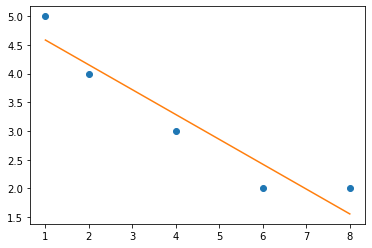

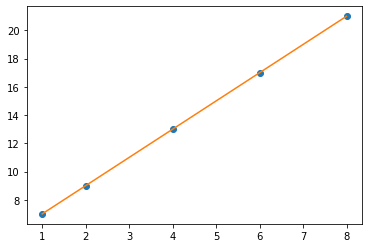

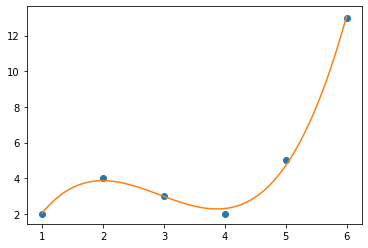

In [20]:
#TESTS

#Test 1: Exact solution does not exist -> residual should hopefully be low
plt.figure()
Xs = np.array([1,2,4,6,8])
Ys = np.array([5,4,3,2,2])

plt.plot(Xs,Ys, 'o')

A = np.array([np.ones(len(Xs)),Xs]).transpose()
b = Ys
sol = least_squares(A,b)
Xl = [Xs[0],Xs[-1]]
Yl = [Xs[0]*sol[1]+sol[0],Xs[-1]*sol[1]+sol[0]]
plt.plot(Xl,Yl)

print("Residual Ax-b:",np.linalg.norm(np.matmul(A,sol)-b))

#Test 2: Exact solution exists -> residual should be 0
plt.figure()
Xs = np.array([1,2,4,6,8])
Ys = np.array([7,9,13,17,21])

plt.plot(Xs,Ys, 'o')

A = np.array([np.ones(len(Xs)),Xs]).transpose()
b = Ys
sol = least_squares(A,b)
Xl = [Xs[0],Xs[-1]]
Yl = [Xs[0]*sol[1]+sol[0],Xs[-1]*sol[1]+sol[0]]
plt.plot(Xl,Yl)

print("Residual Ax-b:",np.linalg.norm(np.matmul(A,sol)-b))

#Test 3: Higher grade polynomial fit, for fun.
plt.figure()
Xs = np.array([1.0,2.0,3.0,4.0,5.0,6.0])
Ys = np.array([2.0,4.0,3.0,2.0,5.0,13.0])

plt.plot(Xs,Ys, 'o')
A = np.array([np.power(Xs,0),np.power(Xs,1),np.power(Xs,2),np.power(Xs,3)]).transpose()
b = Ys
sol = least_squares(A,b)
Xl = np.linspace(Xs[0],Xs[-1],100)
Yl = sol[0]*np.power(Xl,0)+sol[1]*np.power(Xl,1)+sol[2]*np.power(Xl,2)+sol[3]*np.power(Xl,3)
plt.plot(Xl,Yl)

# **Discussion**

The algorithm appears to work correctly in the limited test cases. The time complexity is for the direct solver for $Ax = b$ is $O(n^3)$, as the Gram-Schmidt QR factorization has $O(n^3)$ complexity, and the other parts of the algorithm are quicker and done sequentially.